
# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
<h1 align=center><font size = 5>Segmenting and Clustering Counties for Foreigners in US</font></h1>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

### Background
In the context of this analytical study the foreigners refer to people who hold dual nationalities and U.S. Citizenship. Their ancestry originates from a foreign country or foreigners who migrated to and reside in United States. For simplicity we will be focusing on Pakistani Americans. https://en.wikipedia.org/wiki/Pakistani_Americans
Typically, when foreigners plan to move to US or even while living in US when they want to relocate to another city/neighborhood/county their preference is to live in a demographic area where nationals from their origin are residing. Apart from that there could be different other factors that influence their decision like distance to workplace, school/college/university for their children, climate, price of property/rent and proximity of amenities.

### Problem
The study here analyzes the available information in this regard and helps take this decision by providing options of similar places (counties) based on an individual preference. There could be so many decisive factors but here I limit my study as per following scenario:
A Pakistani doctor is looking for counties in US where there are considerable numbers of Pakistani households plus there are good number of job opportunities for him that are near to the potential residence which eventually saves him/her commute time. His/her location of interest could be hospitals, clinics, medical research institutes where he can offer his services. We need to present him all the options and cluster similar options together in order to help him take an informed decision.
We will use the *k*-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the counties and their emerging clusters.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if we haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if we haven't completed the Foursquare API lab
import folium # map rendering library

import random 
import io
import matplotlib.pyplot as plt 
 
%matplotlib inline

# install lxml to get table from webpage
!pip install lxml

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

## Data <a name="data"></a>

#### Wikipedia Website scraping using python's pandas to get demographic info of Pakistanis in US counties

In [2]:
# Scrape the following Wikipedia page, https://en.wikipedia.org/wiki/Pakistani_Americans
# in order to obtain the data that is in the table and to transform the data into a pandas dataframe 

tables = pd.read_html('https://en.wikipedia.org/wiki/Pakistani_Americans', header=0,
                      keep_default_na=False)
# if table headings in wiki page match our desired headings then load table into pandasframe


headings = ['County','Pakistani Households','County Population','Concentration of Pakistanis']
for table_df in tables:
    current_headings = table_df.columns.values[:4]
    if len(current_headings) != len(headings):
        continue
    if all(current_headings == headings):
        break

print(table_df)
print(table_df.size)

                                  County  Pakistani Households  \
0                Queens County, New York                 15972   
1                 Kings County, New York                 14412   
2                  Cook County, Illinois                 12759   
3                   Harris County, Texas                 11221   
4               Fairfax County, Virginia                  7358   
5         Los Angeles County, California                  7025   
6                DuPage County, Illinois                  4000   
7           Middlesex County, New Jersey                  3788   
8              Orange County, California                  3658   
9                   Dallas County, Texas                  3627   
10             Hudson County, New Jersey                  3369   
11  Fort Bend County, Texas (Sugar Land)                  3216   
12               Nassau County, New York                  3137   
13        Santa Clara County, California                  2824   
14        

#### Pre-Processing - Cleaning and Loading Lat/Long for Counties

<a id='item1'></a>

In [3]:
def getLatLonByCountyName(names):
    
    lat_lon_list=[]
    for address in zip(names):
       
        address1 = ''.join(address)  #convert tuple to string
        #print(address1)
            
        #address = 'Fort Bend County, Texas (Sugar Land)'

        geolocator = Nominatim(user_agent="p_explorer")
        location = geolocator.geocode(address1)
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinates of {} are {}, {}.'.format(address1,latitude, longitude))    
        
        
        # return only relevant information for each nearby venue
        lat_lon_list.append([(
            address1, 
            latitude, 
            longitude, 
            )])

    country_lat_lon = pd.DataFrame([item for lat_lon_list_element in lat_lon_list for item in lat_lon_list_element])
    country_lat_lon.columns = ['County', 
                  'Latitude', 
                  'Longitude', 
                  ]
    
    return(country_lat_lon)

In [4]:
country_lat_lon = getLatLonByCountyName(names=table_df['County'])
print(country_lat_lon)


The geograpical coordinates of Queens County, New York are 40.652492699999996, -73.7914214158161.
The geograpical coordinates of Kings County, New York are 40.64530975, -73.9550230275334.
The geograpical coordinates of Cook County, Illinois are 41.8197385, -87.756525.
The geograpical coordinates of Harris County, Texas are 29.8119769, -95.3741247.
The geograpical coordinates of Fairfax County, Virginia are 38.8156356, -77.2836849.
The geograpical coordinates of Los Angeles County, California are 34.3155072, -118.2096814.
The geograpical coordinates of DuPage County, Illinois are 41.8603735, -88.0906873.
The geograpical coordinates of Middlesex County, New Jersey are 40.4279708, -74.3963102.
The geograpical coordinates of Orange County, California are 33.7500378, -117.8704931.
The geograpical coordinates of Dallas County, Texas are 32.7620405, -96.7790069.
The geograpical coordinates of Hudson County, New Jersey are 40.7381635, -74.0550731.
The geograpical coordinates of Fort Bend Count

#### Join Lat/Long Dataframe with initial Counties Information

In [5]:
#selet only those broroughs that contain string toronto
#df_final = df_final[df_final.Borough.str.contains('Toronto')]

df_final = pd.merge(table_df, country_lat_lon, on='County', how='left')
print(df_final.head())
print(df_final.size)
print(df_final.shape)
#print(df_final.dataType)


                     County  Pakistani Households  County Population  \
0   Queens County, New York                 15972            2296000   
1    Kings County, New York                 14412            2592000   
2     Cook County, Illinois                 12759            5241000   
3      Harris County, Texas                 11221            4337000   
4  Fairfax County, Virginia                  7358            1131000   

  Concentration of Pakistanis   Latitude  Longitude  
0                        3.5%  40.652493 -73.791421  
1                        2.8%  40.645310 -73.955023  
2                        1.2%  41.819738 -87.756525  
3                        1.3%  29.811977 -95.374125  
4                        3.3%  38.815636 -77.283685  
198
(33, 6)


In [6]:
neighborhoods = df_final

#### Postal code is not required as we have already loaded lat/long earlier

In [7]:
neighborhoods = neighborhoods.drop(['County Population'], axis=1)
neighborhoods = neighborhoods.drop(['Concentration of Pakistanis'], axis=1)

Quickly examine the resulting dataframe.

In [8]:
print(neighborhoods.head())
neighborhoods.size

                     County  Pakistani Households   Latitude  Longitude
0   Queens County, New York                 15972  40.652493 -73.791421
1    Kings County, New York                 14412  40.645310 -73.955023
2     Cook County, Illinois                 12759  41.819738 -87.756525
3      Harris County, Texas                 11221  29.811977 -95.374125
4  Fairfax County, Virginia                  7358  38.815636 -77.283685


132

#### Use geopy library to get the latitude and longitude values of US

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>us_explorer</em>, as shown below.

In [9]:
address = 'USA'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of USA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of USA are 39.7837304, -100.4458825.


#### Create a map of US with desired counties superimposed on top.

In [10]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['County'], neighborhoods['Pakistani Households']):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of county

Next, we are going to start utilizing the Foursquare API to explore the counties for venues

#### Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FGJITD3F2G0JNISZ4ESPFVRTWNS521A2GRREPAGOXZ4AS2GG
CLIENT_SECRET:MCNA1DJHI3KWNGK32IM2QSEWOS4NLYZEPF0DO4PGCLAJFQEN


In [12]:
county_data = neighborhoods
print(neighborhoods.head())

                     County  Pakistani Households   Latitude  Longitude
0   Queens County, New York                 15972  40.652493 -73.791421
1    Kings County, New York                 14412  40.645310 -73.955023
2     Cook County, Illinois                 12759  41.819738 -87.756525
3      Harris County, Texas                 11221  29.811977 -95.374125
4  Fairfax County, Virginia                  7358  38.815636 -77.283685


#### Define the variables 

First, let's create the GET request URL. Name your URL **url**.

In [13]:
# type your answer here

#LIMIT = 10000 # limit of number of venues returned by Foursquare API

radius = 25000 # define radius of 25Km 

categoryId = '4bf58dd8d48988d196941735' # categoryId for Hospitial (Retrieved through https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v=20200430)





<a id='item2'></a>

#### Get NearByVenues

#### Let's create a function to repeat the same process to get all near by venues for each county

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print()
        print('County : ',name)
            
        url = 'https://api.foursquare.com/v2/venues/search?intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            len(results)
        )])
        
        print('--------List of Venues--------')
        for v in results:
            #print(v['name'], ',', v['location']['address'] or 'NA')   d.get(key, "empty")
            print(v['name'], ',', v['location'].get('address', "-"))   
        
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['County', 
                  'VenueCount' 
                  ]
    
    return(nearby_venues)

#### Now write the code to run the above function on each county and create a new dataframe called *county_venues*.

In [15]:
# type your answer here

county_venues = getNearbyVenues(names=county_data['County'],
                                   latitudes=county_data['Latitude'],
                                   longitudes=county_data['Longitude']
                                  )

print(county_venues)


County :  Queens County, New York
--------List of Venues--------
NYU Langone Medical Center , 550 1st Ave
Bellevue Hospital Center , 462 1st Ave
New York Presbyterian Hospital Weill Cornell Medical Center , 525 E 68th St Fl 6
Memorial Sloan Kettering Cancer Center , 353 E 68th St
The Mount Sinai Hospital , 1468 Madison Avenue
Northwell - Long Island Jewish Medical Center , 27005 76th Ave
NYU Kimmel Pavilion , 424 E 34th St
NewYork-Presbyterian Brooklyn Methodist Hospital , 506 6th St
Maimonides Medical Center , 4802 10th Ave
Jersey City Medical Center , 355 Grand St
Coney Island Hospital , 2601 Ocean Pkwy
SUNY Downstate , 450 Clarkson Ave
Lenox Hill Hospital , 100 E 77th St
North Shore University Hospital , 300 Community Dr
Morgan Stanley Children's Hospital , 3959 Broadway
Milstein Hospital Building , 177 Fort Washington Ave
Flushing Hospital , 4500 Parsons Blvd
Harlem Hospital Child Psych @ Ronald Brown Building 4Th Fl , 46 W 137 Street
St. Mary Hospital for Children , 29-01 216th S

#### Let's check the size of the resulting dataframe

In [16]:
print(county_venues.shape)
county_venues.head()

(33, 2)


,County,VenueCount
0,"Queens County, New York",30
1,"Kings County, New York",30
2,"Cook County, Illinois",30
3,"Harris County, Texas",30
4,"Fairfax County, Virginia",16


#### Drop Lat/Long as we have alredy used them to get Venue Count

In [17]:


df_final = pd.merge(neighborhoods, county_venues, on='County', how='left')
print(df_final.head())
df_final = df_final.drop(['Latitude'], axis=1)
df_final = df_final.drop(['Longitude'], axis=1)
print(df_final.head())

                     County  Pakistani Households   Latitude  Longitude  \
0   Queens County, New York                 15972  40.652493 -73.791421   
1    Kings County, New York                 14412  40.645310 -73.955023   
2     Cook County, Illinois                 12759  41.819738 -87.756525   
3      Harris County, Texas                 11221  29.811977 -95.374125   
4  Fairfax County, Virginia                  7358  38.815636 -77.283685   

   VenueCount  
0          30  
1          30  
2          30  
3          30  
4          16  
                     County  Pakistani Households  VenueCount
0   Queens County, New York                 15972          30
1    Kings County, New York                 14412          30
2     Cook County, Illinois                 12759          30
3      Harris County, Texas                 11221          30
4  Fairfax County, Virginia                  7358          16


#### Drop County as well as K-means works with only numeric data

In [18]:
df = df_final
df = df.drop('County', axis=1)
df.head()#Let's check how many venues were returned for each neighborhood


pearsoncorr = df.corr(method='pearson')
pearsoncorr

,Pakistani Households,VenueCount
Pakistani Households,1.000000,0.006787
VenueCount,0.006787,1.000000


In [19]:
df.head()

,Pakistani Households,VenueCount
0,15972,30
1,14412,30
2,12759,30
3,11221,30
4,7358,16


#### Normalize Data

In [20]:


#Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

from sklearn.preprocessing import StandardScaler

X = df.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 3.00721104e+00,  6.19172073e-01],
       [ 2.62710845e+00,  6.19172073e-01],
       [ 2.22434589e+00,  6.19172073e-01],
       [ 1.84960372e+00,  6.19172073e-01],
       [ 9.08362498e-01, -1.35363826e+00],
       [ 8.27225214e-01, -2.62187347e+00],
       [ 9.01673047e-02,  5.55119790e-02],
       [ 3.85123371e-02, -1.07180821e+00],
       [ 6.83712120e-03, -8.54030446e-02],
       [-7.16199521e-04, -1.49455328e+00],
       [-6.35793204e-02,  6.19172073e-01],
       [-1.00858613e-01, -9.30893186e-01],
       [-1.20107398e-01,  6.19172073e-01],
       [-1.96371572e-01,  6.19172073e-01],
       [-2.20249812e-01, -2.62187347e+00],
       [-2.97244952e-01,  6.19172073e-01],
       [-3.02605373e-01,  6.19172073e-01],
       [-3.87884801e-01,  6.19172073e-01],
       [-4.13224973e-01,  6.19172073e-01],
       [-4.67316496e-01,  6.19172073e-01],
       [-5.11174487e-01,  6.19172073e-01],
       [-5.85733072e-01, -8.54030446e-02],
       [-6.04738202e-01,  6.19172073e-01],
       [-6.

## Methodology <a name="methodology"></a>

<a id='item4'></a>

Clustering is one of the methods of unsupervised learning and is a common technique used for statistical data analysis in different fields. Its a Machine Learning technique that involves the grouping of data points. If we have set of data points, we can use a clustering algorithm to segment and classify each data point into a specific group. Data points in the same group ideally should have similar properties and/or features

#### K-Means Clustering
There are many models for clustering out there. K-Means model is considered one of the simplest models amongst them. Despite its simplicity, the K-means is vastly used for clustering in many data science applications, especially useful if you need to quickly discover insights from unlabeled data. 
Some real-world applications of k-means:
* Customer segmentation
* Understand what the visitors of a website are trying to accomplish
* Pattern recognition
* Machine learning
* Data compression

K-means will partition our households into mutually exclusive groups, for example, into 4 clusters. The households in each cluster are similar to each other in terms of venue count proximity and number of households in that locality. We can create a profile for each group, considering the common characteristics of each cluster. 

#### Cluster Counties

Run *k*-means to cluster the neighborhood into 4 clusters.

In [21]:
# set number of clusters
kclusters = 4

# run k-means clustering
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_dataset)
k_means = KMeans(init="k-means++", n_clusters=kclusters, n_init=12)
k_means.fit(cluster_dataset)
# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 
print (k_means.labels_)

k_means_cluster_centers = k_means.cluster_centers_
print(k_means_cluster_centers)

[2 2 2 2 1 3 0 1 0 1 0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 0 0]
[[-0.45972837  0.49167753]
 [ 0.02077422 -1.07180821]
 [ 2.42706727  0.61917207]
 [-0.05261482 -2.48095845]]


Let's create a new dataframe that includes the cluster as well as county attributes back

In [22]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#df_final = df_final.drop(['Cluster Labels'], axis=1)
df_final.insert(0, 'Cluster Labels', k_means.labels_)

#county_merged = county_data

neighborhoods = neighborhoods.drop(['Pakistani Households'], axis=1)
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_final = df_final.join(neighborhoods.set_index('County'), on='County')

#county_merged.head() # check the last columns!
df_final.head()

,Cluster Labels,County,Pakistani Households,VenueCount,Latitude,Longitude
0,2,"Queens County, New York",15972,30,40.652493,-73.791421
1,2,"Kings County, New York",14412,30,40.645310,-73.955023
2,2,"Cook County, Illinois",12759,30,41.819738,-87.756525
3,2,"Harris County, Texas",11221,30,29.811977,-95.374125
4,1,"Fairfax County, Virginia",7358,16,38.815636,-77.283685


Finally, let's visualize the resulting clusters

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['County'], df_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

Now, we can examine each cluster and determine the discriminating venue category count and household counts that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

In [24]:
county_merged = df_final

#### Cluster 1

In [25]:
county_merged.loc[county_merged['Cluster Labels'] == 0, county_merged.columns[[1] + list(range(2, county_merged.shape[1]))]]

,County,Pakistani Households,VenueCount,Latitude,Longitude
6,"DuPage County, Illinois",4000,26,41.860374,-88.090687
8,"Orange County, California",3658,25,33.750038,-117.870493
10,"Hudson County, New Jersey",3369,30,40.738163,-74.055073
12,"Nassau County, New York",3137,30,40.741264,-73.587770
13,"Santa Clara County, California",2824,30,37.233325,-121.684635
15,"Montgomery County, Maryland",2410,30,39.140627,-77.207561
16,"Tarrant County, Texas",2388,30,32.751366,-97.335696
17,"Miami-Dade County, Florida",2038,30,25.636425,-80.498947
18,"Broward County, Florida",1934,30,26.159807,-80.462364
19,"Gwinnett County, Georgia",1712,30,33.956687,-84.022747


#### Cluster 2

In [26]:
county_merged.loc[county_merged['Cluster Labels'] == 1, county_merged.columns[[1] + list(range(2, county_merged.shape[1]))]]

,County,Pakistani Households,VenueCount,Latitude,Longitude
4,"Fairfax County, Virginia",7358,16,38.815636,-77.283685
7,"Middlesex County, New Jersey",3788,18,40.427971,-74.396310
9,"Dallas County, Texas",3627,15,32.762040,-96.779007
11,"Fort Bend County, Texas (Sugar Land)",3216,19,29.619679,-95.634946
28,"Dekalb County, Georgia",587,22,33.757561,-84.218651


#### Cluster 3

In [27]:
county_merged.loc[county_merged['Cluster Labels'] == 2, county_merged.columns[[1] + list(range(2, county_merged.shape[1]))]]

,County,Pakistani Households,VenueCount,Latitude,Longitude
0,"Queens County, New York",15972,30,40.652493,-73.791421
1,"Kings County, New York",14412,30,40.645310,-73.955023
2,"Cook County, Illinois",12759,30,41.819738,-87.756525
3,"Harris County, Texas",11221,30,29.811977,-95.374125


#### Cluster 4

In [28]:
county_merged.loc[county_merged['Cluster Labels'] == 3, county_merged.columns[[1] + list(range(2, county_merged.shape[1]))]]

,County,Pakistani Households,VenueCount,Latitude,Longitude
5,"Los Angeles County, California",7025,7,34.315507,-118.209681
14,"Alameda County, California",2726,7,37.609029,-121.899142
30,"Fulton County, Georgia",491,10,34.058039,-84.296128


## Analysis <a name="analysis"></a>

We chose to run the algorithm with cluster size of 4, as per below scatter graph we can see that counties are segmented into 4 segments or clusters which we can name as:
1.	Less workplace options and less to average number of households
    * Workplace options less than 10 and Households count below 8000
2.	Average workplace options and number of households
    * Workplace options between 10 and 20, Households count between 4000 to 8000
3.	Average to high workplace options but low number of households
    * Workplace options higher than 20, Households count less than 4000
4.	High number of workplace options and number of households
    * Workplace options higher than 30 and Households count between 11000 to 16000


#### Plot Scatter Graph

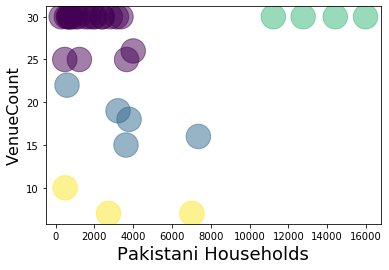

In [29]:
#Insights
#We assign the labels to each row in dataframe.
labels = k_means.labels_
df["Clus_km"] = labels
df.head(5)
#We can easily check the centroid values by averaging the features in each cluster.

df.groupby('Clus_km').mean()
#df.groupby('Clus_km').mean()
#Now, lets look at the distribution of customers based on their age and income:

area = np.pi * ( X[:, 1])**2  
plt.scatter(X[:, 0], X[:, 1], s=600, c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Pakistani Households', fontsize=18)
plt.ylabel('VenueCount', fontsize=16)

plt.show()



## Results and Discussion <a name="results"></a>

At data gathering stage different data sources can be explored to get more recent and detailed data sets. We can also segment based on neighborhoods or state level. The clustering algorithm can be further improved by taking into consideration other factors such as:

•	County Population
•	Concentration of Pakistanis
•	Distance to workplace, school/college/university for a user’s children
•	Climate severity
•	price of property or rent
•	proximity and availability of amenities

Also, Foursquare venue search API is returning currently 30 venues at max and a solution or alternate for this can be used. 
The solution can be made interactive for user inputs and more visual graphs can be included.


## Conclusion <a name="conclusion"></a>

In this study, I utilized Machine Learning’s K-Means clustering algorithm to group available information regarding foreigner population distribution in US into distinct groups or clusters based on household count, workplace count and proximity to workplace. The visual graphs give a user quick insight as to which all counties exist in the same category and what all categories or segments exist out there. This can help them make an informed decision while choosing a county for abode.